# Import necessary library

- Data Handling: pandas (organize data), Numpy (numerical operations)
- Machine Learning: scikit-learn (common algorithms and evaluation)
- ANN model building: scikit-learn (traditional models namely KNN and SVM), tensorflow.keras (deep learning purpose)

In [2]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from scikeras.wrappers import KerasClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout

import warnings
warnings.filterwarnings('ignore')

from IPython.display import clear_output
clear_output()

# Data preprocessing

The below code block performs several essential steps to get the GTZAN music genre dataset ready for machine learning:

- Feature Selection: It focuses on the relevant features for genre classification by excluding potentially unnecessary columns like 'length'.
- Label Encoding: It transforms the genre labels (likely text strings) into numerical values (0-9) for easier processing by machine learning algorithms.
- Data Normalization: It utilizes MinMaxScaler to scale all numerical features within the range of 0 to 1. This helps improve the training process and performance of some algorithms.
- Stratified Split: It splits the data into training and testing sets. The split ensures both sets maintain the same proportion of genres (classes) present in the original dataset. This is crucial for ensuring the model is evaluated on a representative sample of all music genres.
 
By following these steps, the code prepares the GTZAN data in a format suitable for training and evaluating machine learning models for music genre classification.

In [3]:
df = pd.read_csv('../dataset/Dataset.csv')
def preprocess_(df):
    X = df.drop(['label'], axis = 1)
    y = df['label']

    df.label = pd.Categorical(df.label)
    y = np.array(df.label.cat.codes)
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
    return X, y
X, y = preprocess_(df)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y, random_state=42)

# How our stacking works ?
Schematically, our stacking ensemble model looks like this:
<br>
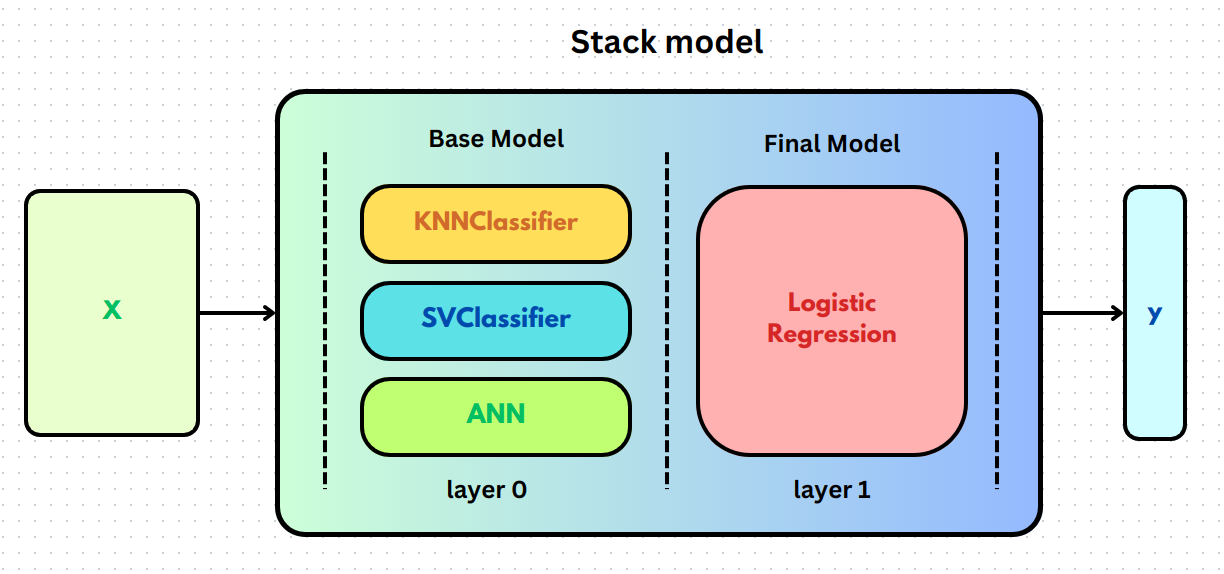
<br>
The structure of a stacking ensemble is the following:

- A set of base models constitute the ensemble: they are fitted and predict independently. These models are also called the “base layer”, or “layer 0” of the stack structure, similarly to a voting ensemble. Those base models might be called “weak learners” as they are in boosting/bagging context, but note that they are not weak learners strictly speaking.
- Another single model will wrap the predictions of the base models and compute the final predictions. This model is also called “final layer”, or “layer 1”

The important thing that makes the specificity of stacking is the following: internally, the final model of the stack does not work with the usual input dataset X, but instead learns/predict from the predictions of the base models. The idea is to use a model to fit/learn how the base models predict the output y, compare those predictions to the actual true y_true.

After the model has been fit, the predict process is simply the following: for a new X dataset (X or even a single sample x):

- All base model predictions are computed, independently: for model in base_models: y_pred=model.predict(X)
- All these y_pred vectors are concatenated horizontally, so to create a new 2D dataset, where each column represents the predictions for a given base model, we’ll call this matrix X_final because it represents the 2D input dataset of the final estimator.
- This X_final 2D dataset is used by the final estimator to predict the actual, final prediction: final.predict(X_final)

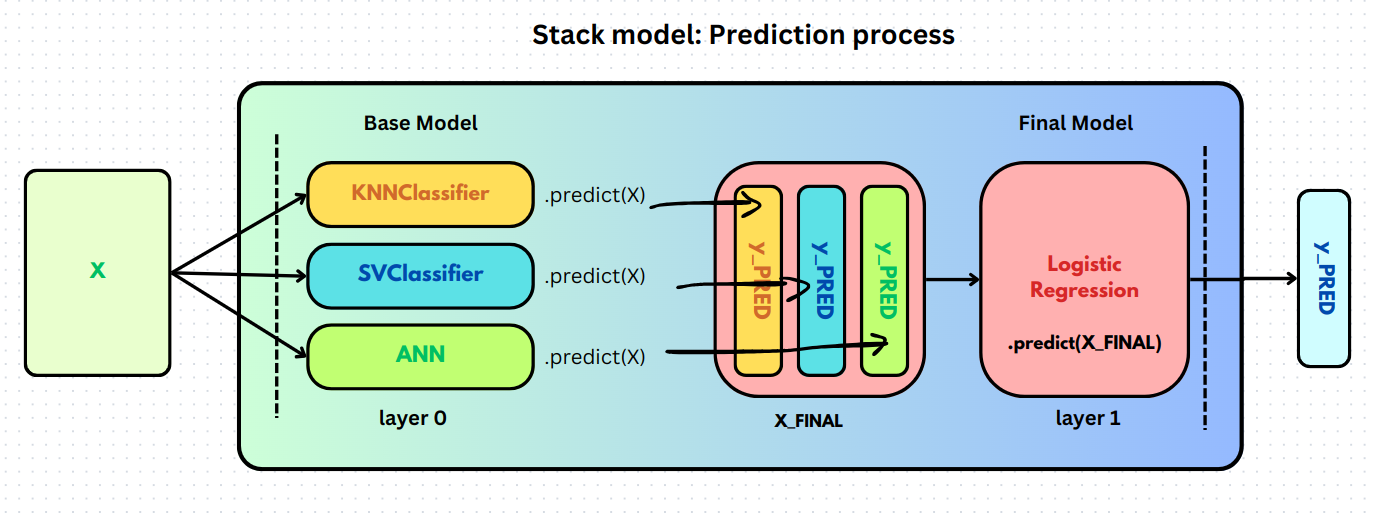

<p>   Put differently, there is an intermediate 2D dataset matrix that is created internally, composed of the y-predictions of the base models, and this matrix is used as the input for the final model — meaning the final model takes a 2D matrix of y-space values, and output the actual 1D prediction of y-space values.</p>
<p>   Another way to see stacking is as a voting model, except instead of simply taking the average/most-voted prediction, we feed those predictions to another model. Put differently, we could mimic voting with stacking by using a plain averaging/argmax model as the final model.</p>
<p>  Usually, the final model used is a simple LinearRegression for regression problems and LogisticRegression of classification problems, and those are the defaults of scikit-learn StackingClassifier and StackingRegressor. The step of combining the base models predictions by the final estimator is sometimes called “blending” as all the models predictions are blended into a single prediction.</p>

# Fitting the stack model in the right way

The algorithm used to fit a stack can be decomposed into 2 steps. The first one is pretty simple, while the second one needs a bit more explanation:

- step 1: all base models (those from layer 0) are fitted completely independently and using the whole X/y dataset. In other words, the first step is equivalent to: for model in base_models: model.fit(X,y)
- step 2: the final estimator is fitted using a cross-validation scheme with unfitted base models
The first step is pretty self-explanatory: when the fit method is called on the stack model stack.fit(X,y), the X and y are handled to each of the base models and they are fitted independently from each other. This step is equivalent to for model in base_models: model.fit(X,y). Those fitted estimators are stored in the stack.estimators_ attribute of the stack model.

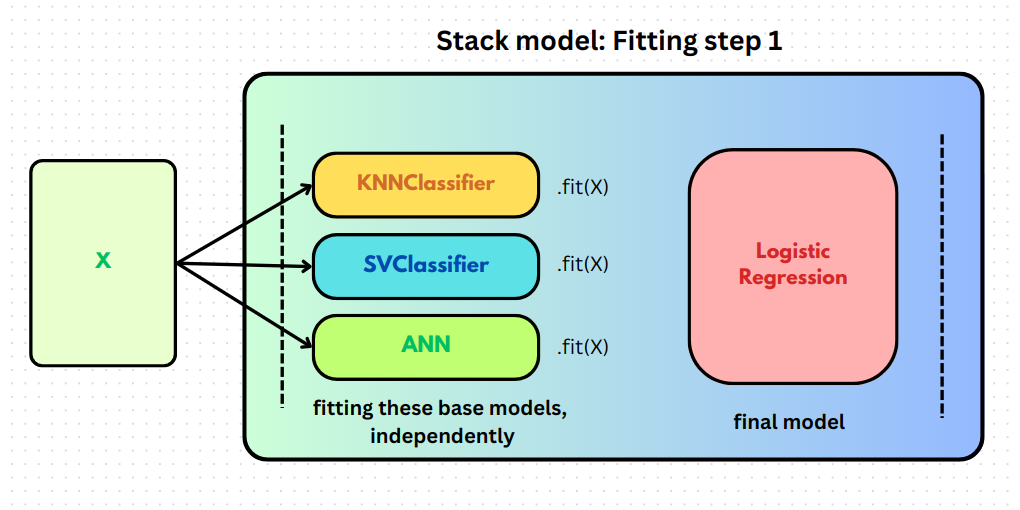

Then in order to train the final estimator, a different approach is used. We already have the target output y for that fitting, but we still need to generate the intermediate X_final dataset created by the predictions of the base models. Using the .predict method on the already fitted estimators would lead to some kind of overfitting since the input X has already been seen and trained on by the base estimators.

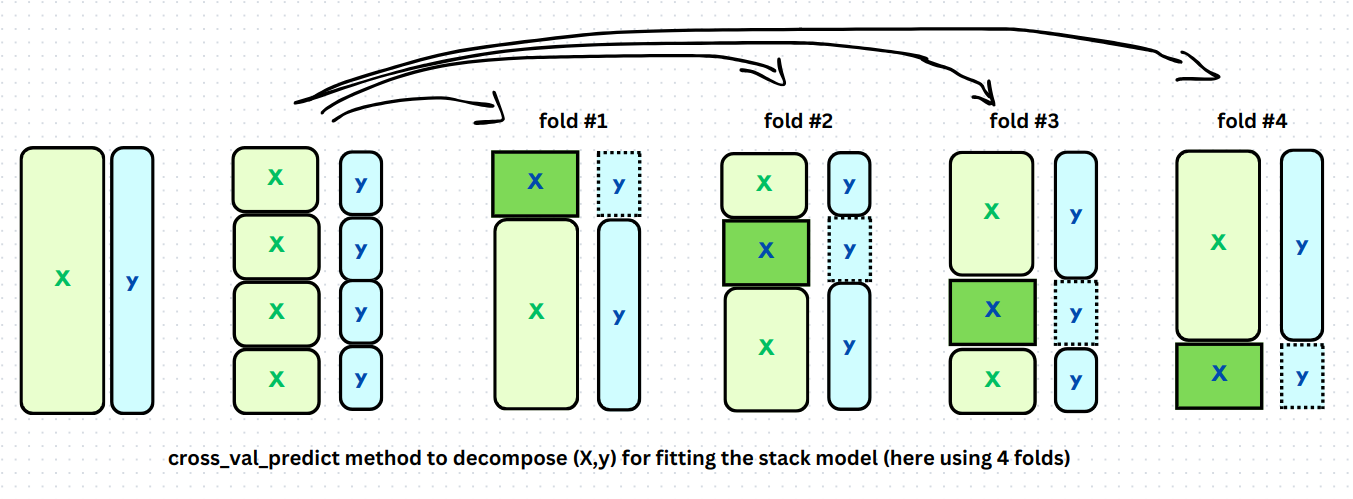

In other words, we cannot use the already trained base estimators to feed the input dataset to fit the final estimator. Instead, each estimator is fed with the same cross-validation fold to the cross_val_predict function to generate a y_pred for all the base estimators. Those base predictions are then horizontally concatenated in an X_final training dataset so the final estimator fits with final_model.fit(X_final, y).

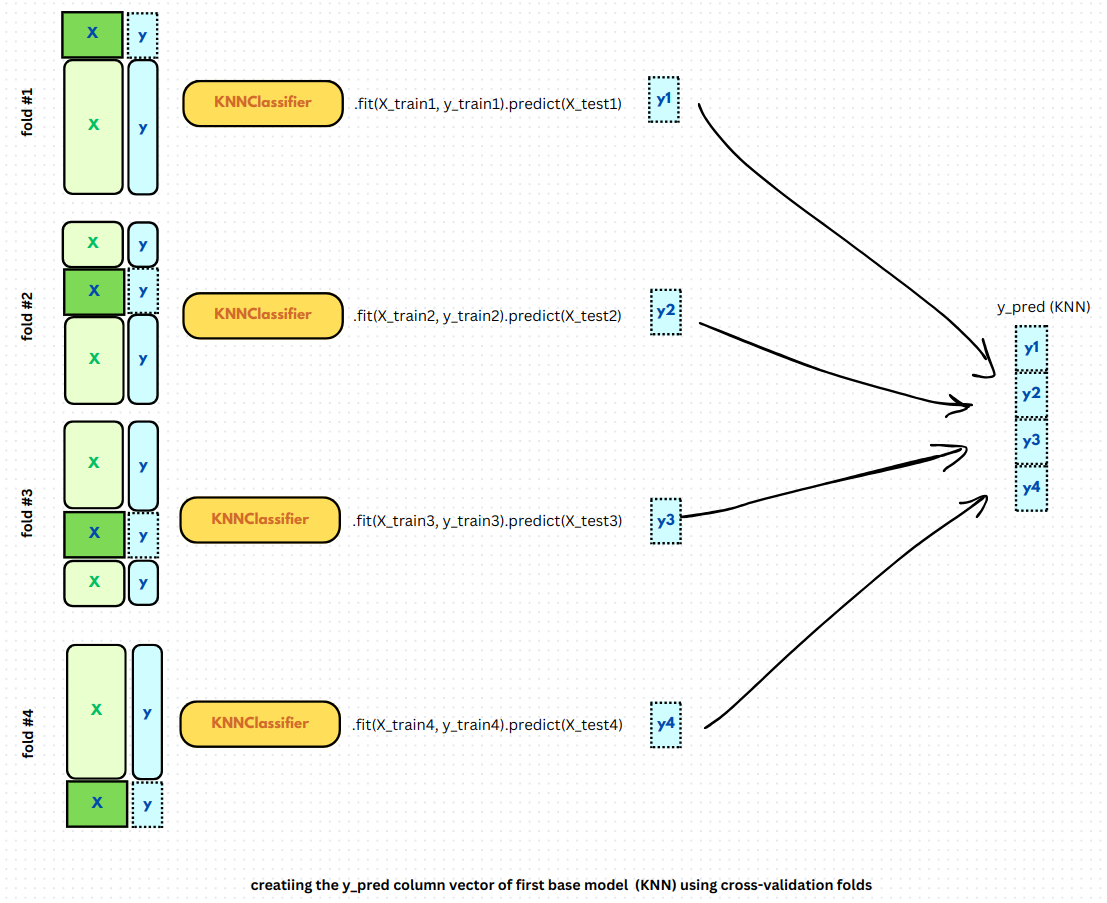

Now we know to decompose the problem as: “the X dataset the final estimator uses to fit on the target y is created by concatenating the predicted values by all estimators given by the cross_val_predict function” (using the same cv strategy for all estimators, in order to account for the fact that all base estimators always see the same input/output). This means that the fitted base models from the first step (those fitted with the whole X dataset) are not used to fit the final estimator. Instead, a copy of the unfitted base models are used for each fold, and the predictions for each folds are concatenated (vertically for each model, and horizontally to create X_final).

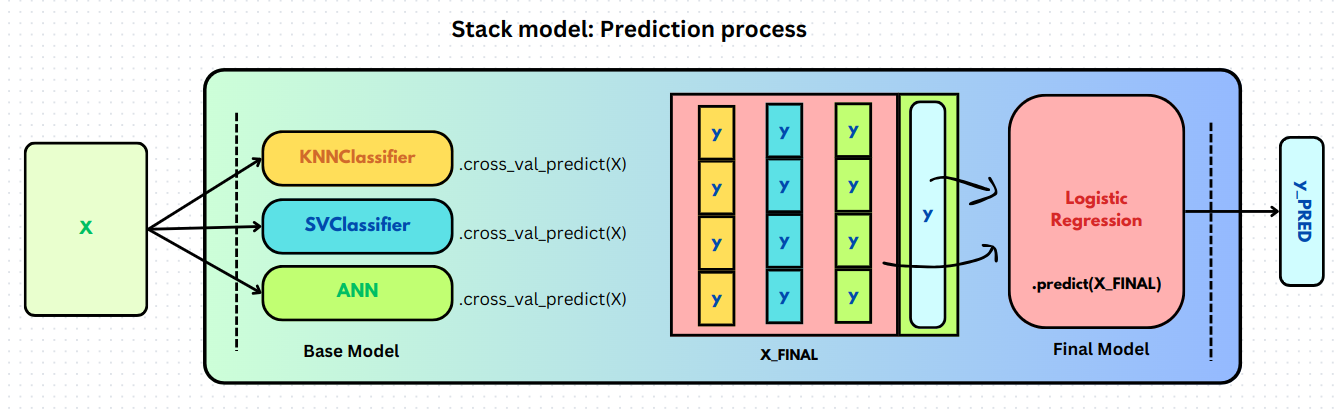

This way, the final estimator is fitted with predictions from the base models on samples that were not already seen by the base models.

Another way to see this fitting procedure is to represent the intermediate 2D dataset X_final from the cross-validation folds decomposition: the X dataset is split into N folds (X_train, X_test, y_train, y_test). The folds must respect the “partition” criteria, such that each individual sample is used only once a test set. For each of those splits, a copy of unfitted-base models is fitted using .fit(X_train, y_train), and the corresponding predictions are computed using .predict(X_test). This way, we get the y_pred for all base models, and for all splits. The final X_train is simply the vertical concatenation of the predictions for all splits.

# Restacking : a better way to enhance performance

The stacking architecture allows for an additional customization of the model, you can see this as a hyperparameter that allows us to tune how the model works. The idea is really simple: in addition to the horizontally-stacked predictions of the base models, the original input X dataset is also added to the input of the final estimator. This way, the final estimator can find more information in the data, including both the predictions of the base models and the original data. Put another way, the stacking model’s complexity is increased, by increasing the number of features of the input of the final model.

In scikit-learn, this is done through the passthrough=True parameter of the stack models.

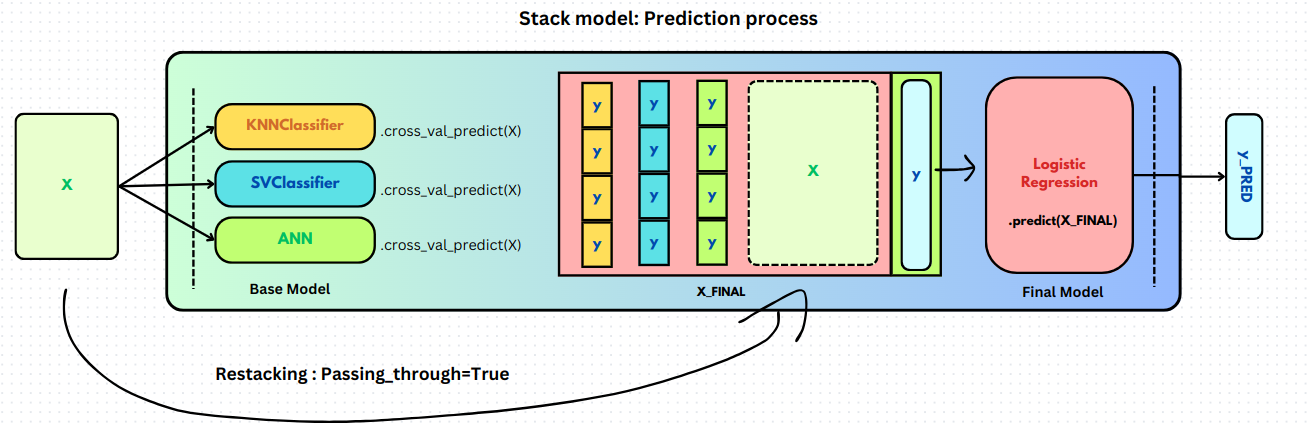

Obviously, the X matrix is added to X_final both at fit time and predict time.

In [6]:
KNN = KNeighborsClassifier(n_neighbors=2, weights='distance',p=1)

SVM = SVC(kernel='rbf', gamma='scale', C=200, probability=True)

def create_nn():
    model = Sequential([
        Input(shape=(57,)), 
        Dense(300, activation='relu'),                                                                      
        Dense(300, activation='relu'),
        Dense(300, activation='relu'),
        Dense(300, activation='relu'),
        Dense(300, activation='relu'),
        Dense(10, activation='softmax')
    ])
    adam = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=adam,
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

NN = KerasClassifier(build_fn=create_nn, epochs=100, batch_size=64, verbose=0)

# Define the base model
base_models = [('knn', KNN), ('svm', SVM), ('nn', NN)]

# Our stack ensemble models
stack = StackingClassifier(
    estimators=base_models,
    final_estimator= LogisticRegression(),
    passthrough=True,
)

In [7]:
stack.fit(X_train,y_train)
y_pred_stack = stack.predict(X_test)
print(accuracy_score(y_pred_stack,y_test))

0.8741172858458705


In [8]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_stack))

              precision    recall  f1-score   support

           0       0.91      0.94      0.93       667
           1       0.96      0.96      0.96       667
           2       0.82      0.88      0.85       706
           3       0.89      0.87      0.88       617
           4       0.88      0.89      0.88       602
           5       0.96      0.95      0.95       700
           6       0.86      0.84      0.85       685
           7       0.77      0.78      0.77       593
           8       0.92      0.90      0.91       656
           9       0.76      0.70      0.73       621

    accuracy                           0.87      6514
   macro avg       0.87      0.87      0.87      6514
weighted avg       0.87      0.87      0.87      6514



In [31]:
import os 
import pickle

if os.path.exists('/home/khangpt/MUSIC-GEN-PROJ/saved_model/stack_model.pkl'):
    os.remove('/home/khangpt/MUSIC-GEN-PROJ/saved_model/stack_model.pkl')
with open('/home/khangpt/MUSIC-GEN-PROJ/saved_model/stack_model.pkl','wb') as file:
    pickle.dump(stack, file)
